# Домашнее задание 2 по ML
Нужно написать python класс градиентного бустинга и побить другую модель на предоставленном baseline

## Критерии оценки
- Ваш ноутбук будет запущен через ```run all``` - он не должен упасть (допускается падение из-за отсутствия библиотеки, которую можно поставить через pip install)
- Вот этот код (внизу ноутбука) ```assert imp_my_little_model > imp_baseline_model``` не вызвал ошибок (успешно отработал)

- реализованы следующие гиперпараметры
  - вы реализовали гиперпараметр ```learning_rate```
  - вы реализовали гиперпараметр ```n_estimators```
  - вы реализовали гиперпараметр ```max_depth```
  - вы реализовали гиперпараметр ```bagging_fraction```

- Вы реализовали [Huber loss function](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BF%D0%BE%D1%82%D0%B5%D1%80%D1%8C_%D0%A5%D1%8C%D1%8E%D0%B1%D0%B5%D1%80%D0%B0) - она записана как отдельная def функция вне класса - и используется в вашем классе для расчета

----
*Для успешной сдачи дз нужно выполнить полностью каждый пункт выше*

- оценка 5 будет поставлена, если каждый пункт выполнен без недочетов
- оценка 4 будет поставлена, если будет найден один недочет
- незачет будет пославлен, если недочетов будет два или более
- незачет будет пославлен, если какой либо пункт не выполнен


In [1]:
%autosave 60

Autosaving every 60 seconds


In [47]:
# !pip install shap

import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


In [4]:
np.random.seed(42)

In [5]:
data, target = shap.datasets.california()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### Не меняйте название для предскзаний preds_my_little_model, иначе не получится сдать это ДЗ (сломается код)

Некоторые правила
- Нельзя использовать никакие другие алгоритмы моделей внутри вашего класса, кроме DecisionTreeRegressor.
- Код вашего бустинга должен быть написан в классе, у класса должно быть два ожидаемых метода : ```fit``` и ```predict```.
- Нельзя менять датасет (и модифицировать тоже, например заполнять nan или применять scaler) или baseline модель
- Нельзя поднимать число n_estimators вашей модели выше 100 (чтобы результат был сравним с моделью-конкурентом ```GradientBoostingRegressor```)

# *это место для вашего кода* ↓↓↓


In [54]:
def huber_loss(Y_true, Y_pred, delta=1.):
    return np.array([
    0.5* (y_true - y_pred)**2 if np.abs(y_true - y_pred) <= delta   
    else delta * (np.abs(y_true-y_pred) - 0.5*delta)
    for y_true, y_pred in zip(Y_true,Y_pred)]
    )
    
def grad_huber_loss(Y_true, Y_pred, delta=1.):
    return np.array([
    -(y_true - y_pred) if np.abs(y_true - y_pred) <= delta   
    else -delta * np.sign(y_true-y_pred) 
    for y_true, y_pred in zip(Y_true,Y_pred)]
    )

In [93]:
class MyGradBoosting:
    def __init__(
        self,
        learning_rate=0.1,
        n_estimators=100,
        max_depth=5,
        random_state=10,
        bagging_fraction=0.75
    ):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.bagging_fraction = bagging_fraction


    def fit(self, X, y):

        self.models = []
        self.losses = []
        self.y_mean = np.mean(y)


        pred = np.ones(X.shape[0]) * self.y_mean
        self.losses.append(np.mean(huber_loss(y,pred)))
    

        for _ in range(self.n_estimators):
            grad = -1 * grad_huber_loss(y, pred)

            indices = np.random.RandomState(self.random_state).randint(0, len(X), size=int(self.bagging_fraction*len(X)))
            X_ = X.iloc[indices]
            y_ = grad[indices]

            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model = model.fit(X_,y_)
            
            
            pred += self.learning_rate*model.predict(X)

            self.models.append(model)
            self.losses.append(np.mean(huber_loss(y, pred)))

        
        return self

    def predict(self, samples):

        predictions = np.ones(len(samples)) * self.y_mean

        for model in self.models:
            predictions += self.learning_rate * model.predict(samples)
        
        return predictions

In [94]:
my_little_model = MyGradBoosting()
my_little_model.fit(X_train, y_train)

preds_my_little_model = my_little_model.predict(X_test)

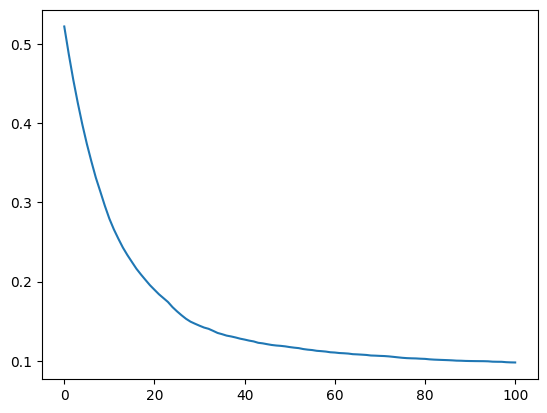

In [95]:
plt.plot(np.arange(len(my_little_model.losses)), my_little_model.losses)

In [96]:
# самопроверки
assert preds_my_little_model.shape == y_test.shape, 'что-то не так с выходным размером предикта'

# *это место для вашего кода* ↑↑↑

### *ниже ничего менять не нужно*
## Это класс судья - он решит, какая модель оказалась лучше, ваша, или GradientBoostingRegressor из sklearn
Если ячейка ниже завершилась ошибкой, нужно поменять код вашей модели и попробовать еще раз, до тех пор, пока не получите сообщение "Ура, получилось!"

In [97]:
baseline_model = GradientBoostingRegressor(random_state=4, verbose=0)
baseline_model = baseline_model.fit(X_train, y_train)
preds_baseline_model = baseline_model.predict(X_test)
print('mape - ваша модель', mean_absolute_percentage_error(y_test, preds_my_little_model))
print('mape - baseline', mean_absolute_percentage_error(y_test, preds_baseline_model))

final_estimator = RandomForestRegressor(random_state=16)
final_estimator = final_estimator.fit(
    np.hstack((preds_baseline_model.reshape(-1, 1), preds_my_little_model.reshape(-1, 1))),
    y_test
)

imp_baseline_model, imp_my_little_model = final_estimator.feature_importances_
result_message = f"baseline важность: {imp_baseline_model:0.3f}; важность вашей модели: {imp_my_little_model:0.3f}"

assert imp_my_little_model > imp_baseline_model,  f'попробуй еще раз: {result_message}'
print('Ура, получилось!',  result_message)

mape - ваша модель 0.19548134238261822
mape - baseline 0.2152446498010688
Ура, получилось! baseline важность: 0.123; важность вашей модели: 0.877
